In [1]:
import pandas as pd
import json
import networkx as nx
import nx_altair as nxa
import json
import squarify
import altair as alt
import numpy as np
import matplotlib
from sklearn.cluster import AgglomerativeClustering
from networkx.algorithms.community import *
from scipy.cluster.hierarchy import dendrogram,leaves_list
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

## Information Visualization II

## School of Information, University of Michigan

## Week 3:

- Hierarchies and Networks

## Assignment Overview
### The objectives for this week are for you to:

- Examine practical methods for visualizing hierarchical and network datasets
- Experiment with external libraries (squarify, networkx, and nx-altair)

### The total score of this assignment will be
- Problem 1 - 30 points
- Problem 2 - 50 points
- Problem 3 - 20 points


### Resources:

- We have created datasets for you for this week based on the Simpsons' TV show (more on this in a moment...). There are a number of files we will use in the [assets](./assets/) directory.

### Important notes:
1) This assignment will look long, but we've written a lot of helper functions for you. The amount you will need to implement will be relatively small.

2) Grading for this assignment is entirely done by manual inspection.

3) When turning in your PDF, please use the File -> Print -> Save as PDF option ***from your browser***. Do ***not*** use the File->Download as->PDF option. Complete instructions for this are under Resources in the Coursera page for this class.

If you're having trouble with printing, take a look at [this video](https://youtu.be/PiO-K7AoWjk).


***

In [2]:
# enable correct rendering (unnecessary in later versions of Altair)
alt.renderers.enable('default')

# uses intermediate json files to speed things up
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## The Simpsons....

For today's exercise, we're going to be using data from the Simpsons! [The Simpsons](https://en.wikipedia.org/wiki/The_Simpsons) is an animated comedy that has appeared on American TV continuously since 1989. They are up to nearly 700 episodes over 32 seasons(!) on television, not to mention the movies, books, theme parks, and many other cultural artifacts. Basically, they're [everywhere](https://en.wikipedia.org/wiki/Non-English_versions_of_The_Simpsons). The main Simpsons family--Homer (the father), Marge (the mother), and the kids: Bart, Lisa, and Maggie--have been joined by 100s of characters over the years.

!["simpsons family"](assets/family.png)

The Simpsons have lasted long enough that it's probably one of the few shows that are still on the air that need to have older episodes edited or removed because they're no longer appropriate. Nonetheless, jokes and quotes from the Simpson have become engrained in our culture. For this assignment, we will be analyzing key quotes from the history of the Simpsons as a network problem. 

We have extracted [quote data from the wikiquotes project](https://en.wikiquote.org/wiki/The_Simpsons). For each season, we look at each episode. For each episode, we identify the quotes recorded in wikiquotes.

While some quotes are "one-liners" by a single character:
* **Homer**: Aww, it makes no sense; I haven't changed since high school and all of a sudden I'm uncool.

We are interested in interactions between characters. For example:
* **Homer**: Doughnut?
* **Lisa**: No, thanks. Do you have any fruit?
* **Homer**: This has purple stuff inside. Purple is a fruit.

These multi-character quotes will become the "edges" in our network, but more on that in a bit. We're going to start with a simpler analysis of the hierarchical data in this database.


## Problem 1 (30 points)

For this first problem, we are going to look at the hierarchical representation of the quote database. Specifically, we have multiple seasons. For each of the seasons, we have multiple episodes. Finally, for each of the episodes, we have multiple characters who have participated in funny/memorable scenes. For example, Homer has participated in 972 quoted conversations in the dataset! Bart comes in a remote second at 548. Our goal is to have a visualization that allows us to compare which seasons/episodes/characters had the most quoted conversations. Ideally, we'd also like to know if a certain character had many conversations in one episode and fewer in others? Were there any outlier episodes with lots of conversations? Was there one season with many conversations? All these domain tasks map neatly to abstract problems of hierarchical data. Hierarchical visualization techniques will be a reasonable solution given these questions.

Abstractly, our data looks something like this:

![hierarchy of interactions](assets/hier.png)

What this tells us is that there are 5076 conversations in our dataset. Season 2, for example, has 124 of those. In Season 2, Episode 1 had 7 quotes, and Bart was responsible for 2 of them (the episode and quote numbers are made up for this example). Notice that the same characters can appear multiple times. 

To help us with the real data, we have constructed the hierarchy as a nested data structure. Let's load the data in:

In [3]:
with open('assets/simpsonshier.jsonl') as json_file:
    allseasons = json.load(json_file)

In [4]:
# this variable is a massive JSON object with a hierarchy of seasons -> episodes -> characters. Each "Node"
# hierarchy is a dictionary which has an id, a type (one of 'season','episode', or 'character'), an optional
# label (episodes had names as well as numerical ids), the value (the number of quotes), and children (a
# list of nodes that sit underneath)

allseasons

# for example, we can find season 2's quote quote:
season2 = allseasons[1]
print("season ",season2['id'], "had", season2['value'], "quotes")

# for the first episode of season 1 we see the following
season2e1 = season2['children'][0]
print(season2e1)

# you'll see that this episode was called "Bart Gets and F" and it had 7 quotes. Bart was responsible for 2 of these

season  s02 had 124 quotes
{'id': 's02e14', 'type': 'episode', 'label': 'Bart Gets an F', 'value': 7, 'children': [{'id': 'Bart', 'type': 'character', 'value': 2}, {'id': 'Mrs. Krabappel', 'type': 'character', 'value': 1}, {'id': 'Martin', 'type': 'character', 'value': 1}, {'id': 'Otto', 'type': 'character', 'value': 1}, {'id': 'Sherri', 'type': 'character', 'value': 1}, {'id': 'Terri', 'type': 'character', 'value': 1}]}


Recall that we have two main ways to display hierarchies. Node link diagrams (rather like the image above) and space-filling versions such as TreeMaps. We're going to demonstrate how you can build a treemap using a combination of tools. We'll visualize only some of the seasons to keep things a bit sane, but the first 6 roughly look like this:

![treemap1](assets/treemap1.png)

More on the color encoding later, but you can see the 6 black boxes (seasons), the multiple gray boxes (the episodes), and the colorful objects inside of that are the characters. Unfortunately, Altair doesn't have a treemap layout built in. We'll be using the [squarify](https://github.com/laserson/squarify) library to generate the coordinates. Squarify works by generating one level of the hierarchy at a time. So we need a function that lays out the seasons, and then for each episode re-runs squarify but restricts it to the space allocated to the season. After that we re-run squarify to plot the position of each character in that episode. We've written this recursive function for you below. In the end it returns a dataframe with the bits we need to plot:

In [5]:
def rectangleIter(data,width,height,xof=0,yof=0,frame=None,level=-1,parentid=""):
    # data: hierarchical structured data
    # width: width we can work in
    # height: height we can work in
    # xof: x offset
    # yof: y offset
    # frame: the dataframe to add the data to, if None, we create one
    # the level of the treemap (will default to 0 on first run)
    # parentid: a string representing the parent of this node
    # returns dataframe of all the rectangles
    
    if (frame is None):
        frame = pd.DataFrame()
    level = level + 1
    values = []
    children = []
    for parent in data:
        values.append(parent['value'])
        if ('children' in parent):
            children.append(parent['children'])
        else:
            children.append([])
            
    # normalize
    values = squarify.normalize_sizes(values, width, height)
   
    # generate the 
    padded_rects = squarify.padded_squarify(values, xof, yof, width, height)
    
    i = 0
    for rect in padded_rects:
        # adjust the padding and copy the useful pieces of data over
        parent = data[i]
        rect['width'] = rect['dx']
        rect['height'] = rect['dy']
        del rect['dx']
        del rect['dy']
        rect['x2'] = rect['x'] + rect['width'] - 2
        rect['y2'] = rect['y'] + rect['height'] - 2
        rect['x'] = rect['x'] + 2
        rect['y'] = rect['y'] + 2
        rect['width'] = rect['x2'] - rect['x']
        rect['height'] = rect['y2'] - rect['y']
        rect['id'] = parent['id']
        rect['type'] = parent['type']
        rect['value'] = parent['value']
        rect['level'] = level
        if 'label' in parent:
            rect['label'] = parent['label']
        else:
            rect['label'] = parent['id']
        rect['parentid'] = parentid
        frame = frame.append(rect,ignore_index=True)
        
        # iterate
        frame = rectangleIter(children[i],rect['width'],rect['height'],rect['x'],rect['y'],
                              frame=frame,level=level,parentid=parentid+" → "+rect['label'])
        i = i + 1
    return(frame)

In [6]:
shortseason = allseasons[0:6]                   # let's grab the first 6 seasons
rect_table = rectangleIter(shortseason,800,800) # and run them through the treemap algorithm

In [7]:
# let's look at what's inside
rect_table.sample(5)

,height,id,label,level,parentid,type,value,width,x,x2,y,y2
728,8.586000,Skinner,Skinner,2.0,→ s05 → The Boy Who Knew Too Much,character,1.0,24.890096,714.972003,739.862098,404.061059,412.647059
240,19.908409,Lisa,Lisa,2.0,→ s03 → Treehouse of Horror II,character,1.0,10.805714,156.348571,167.154286,542.136992,562.045401
92,9.668248,Barney,Barney,2.0,→ s02 → Dancin' Homer,character,1.0,20.031056,9.000000,29.031056,215.042694,224.710942
47,55.550865,s01e11,The Crepes of Wrath,1.0,→ s01,episode,6.0,43.107259,115.624733,158.731992,96.096194,151.647059
212,11.272273,Faith Crowley,Faith Crowley,2.0,→ s03 → Mr. Lisa Goes to Washington,character,1.0,14.708571,115.834286,130.542857,475.684037,486.956310


In [8]:
rect_table[rect_table['level']==0]

,height,id,label,level,parentid,type,value,width,x,x2,y,y2
0,151.647059,s01,s01,0.0,,season,67.0,222.571429,3.000000,225.571429,3.000000,154.647059
66,285.764706,s02,s02,0.0,,season,124.0,222.571429,3.000000,225.571429,160.647059,446.411765
200,344.588235,s03,s03,0.0,,season,149.0,222.571429,3.000000,225.571429,452.411765,797.000000
346,415.647059,s04,s04,0.0,,season,163.0,201.908163,231.571429,433.479592,3.000000,418.647059
511,415.647059,s05,s05,0.0,,season,285.0,357.520408,439.479592,797.000000,3.000000,418.647059
739,372.352941,s06,s06,0.0,,season,402.0,565.428571,231.571429,797.000000,424.647059,797.000000


What you'll find inside the table is everything you need to create your visualization using Altair. There are coordinates for the rectangle (the start point: x,y; the end points: x2,y2, and the width, height). You'll also find the id/label for each rectangle, a numerical level (0,1, or 2 in this case), and the type of rectangle (character, episode, or season).

## Problem 1.1

Using Altair, generate a treemap using the ```rect_table``` dataframe. Regenerate the image above. Use the same color scheme for seasons and episodes as we did (your character colors may vary). We used 800 pixels square for the visualization. Complete the function ```staticTreemap``` that returns this Altair visualization given the rectangles frame.

Some hints:
* think layering
* try to get one layer (maybe rectangles for the series objects) to work first and then add more

In [9]:
def staticTreemap(inputFrame):
    
    # input inputFrame the rectangles frame as described above
    # return a static Altair treemap visualization
    
    # YOUR CODE HERE
#     raise NotImplementedError()

# rect_table[rect_table['level']==0]
    layer0 = alt.Chart(inputFrame[inputFrame['level']==0]).mark_rect(fill='black').encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
#         y =alt.Y('y:O', axis=None),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2')
    )
    layer1 = alt.Chart(inputFrame[inputFrame['level']==1]).mark_rect(fill='grey').encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
#         y =alt.Y('y:O', axis=None),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2')
    )
    layer2 = alt.Chart(inputFrame[inputFrame['level']==2]).mark_rect().encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
#         y =alt.Y('y:O', axis=None),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2'),
        color=alt.Color('label', legend=None)
    )
    
    return (layer0 + layer1 + layer2).configure_view(
        strokeWidth=0
    ).properties(
    width=800,
    height=800,
        padding=0
    )

In [10]:
# if you did this correctly, the following should work
staticTreemap(rect_table)

alt.LayerChart(...)

## Problem 1.2

While the solution above looks cool, it's really not so helpful for understanding the data. We can see that seasons are different in terms of the number of quotes, there are differences in episodes, and some characters have many quotes in one episode and few in the others. But we have no idea what these seasons, episodes, or characters are!

We could try to add labels, but that might become unreadable pretty fast. Instead, your task is to add interactivity to make this visualization more usable. You can pick your strategy for doing this. We've created the following example to get you thinking:

!["animated treemap](assets/hierinteractive.gif)

To help us determine what we're looking at, we've added tooltips and to aid with comparisons between the same characters over mutliple episodes/seasons we've added the ability to select characters of interest. You are welcome to adopt whatever strategy you think will be expressive/effective here.

Complete the function ```interactiveTreemap``` to return this interactive Altair visualization.

In [11]:
def interactiveTreemap(inputFrame):
    # input inputFrame the rectangles frame as described above
    # return a static Altair treemap visualization
    
    # YOUR CODE HERE
#     raise NotImplementedError()

    layer0 = alt.Chart(inputFrame[inputFrame['level']==0]).mark_rect(fill='black').encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2')
    )
    layer1 = alt.Chart(inputFrame[inputFrame['level']==1]).mark_rect(fill='grey').encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2')
    )
    
#     selection = alt.selection_single()
    selection = alt.selection_multi(fields=['id'])
#     zoom = alt.selection_interval(bind='scales')
    
    layer2 = alt.Chart(inputFrame[inputFrame['level']==2]).mark_rect().encode(
        x =alt.X('x:O', axis=None),
        y =alt.Y('y:O', axis=None, scale=alt.Scale(reverse=True)),
        x2=alt.X2('x2'),
        y2=alt.Y2('y2'),
#         color=alt.Color('label', alt.value('lightgray'), legend=None),
#         color=alt.Color('label', legend=None)
        color=alt.condition(selection, 'label', alt.value('lightgray'), legend=None),
        tooltip=['parentid', 'id', 'value']
    ).add_selection(
    selection
)
    
    return (layer0 + layer1 + layer2).configure_view(
        strokeWidth=0
    ).properties(
    width=800,
    height=800,
        padding=0
    )

In [12]:
interactiveTreemap(rect_table)

alt.LayerChart(...)

## Problem 2 (50 points)

For our next analysis, we're going to look a little more closely at conversation networks. Each quotable conversation can be modeled as a small network. Nodes will correspond to the characters, and edges will be the number of conversations two character's co-occurred in. For example, if Bart, Homer, and Lisa are in the same quote, we would construct 3 undirected edges: Bart to Homer,  Bart to Lisa, and Lisa to Homer. By aggregating all these conversations together (over episodes or seasons), we can compute the "weight" of an edge: the total number of quoted conversations those characters interacted over.  From this kind of network, we can identify who the central characters are. Who is interacting with the most others in a quotable way? Are there small communities?

For this problem, we are going to use two libraries to help us out: [networkx](https://networkx.org/)--a library for manipulation and analysis of graph data structures (it will also generate layouts), and [nx-altair](https://github.com/Zsailer/nx_altair) a library that can generate Altair plots from networkx data. We don't expect you to learn all the pieces of these libraries. However, we'll explore a few functions to get some interesting visualizations.

Let's start by taking a look at this network data.

In [13]:
# helper function to load the data
def loadData(filepath):
    articles = []
    with open(filepath) as fp:
        for docid, line in enumerate(fp):
            #print(line)
            #print(docid)
            doc = json.loads(line)
            char1 = doc['c1']
            char2 = doc['c2']
            articles.append(doc)
    return pd.DataFrame(articles)

In [14]:
# we're going to load a data frame representation of the network to start
simpsons = loadData('assets/simpsons.jsonl')

In [15]:
# let's look inside
simpsons.sample(5)

,season,episode,lineid,c1,c2
587,4,Brother from the Same Planet,173,Milhouse,Mrs. Krabappel
2371,9,The Cartridge Family,841,Lisa,Marge
2565,9,The Last Temptation of Krust,926,Lisa,Marge
973,5,Lady Bouvier's Lover,318,Mr. Burns,Mrs. Bouvier
2517,9,Das Bus,912,Lisa,Ralph


We see a row for every edge. The ```season``` and ```episode``` column has the season the conversation happened in. The ```lineid``` is a unique id for the conversation (note that if the conversation involved more than two people, we'd see the same lineid multiple times; see the Bart/Homer/Lisa example above). The columns ```c1``` and ```c2``` hold the two characters' names (the name in c1 will always be alphabetically before c2). We have tried to clean up this data as much as possible, but you may see some inconsistencies with names. For example, you might find different entries for "Skinner" and "Principal Skinner" even though they are the same character.

Next, we'll build our network using networkx. 

In [16]:
# utility classes

def buildNetwork(quoteFrame):
    # takes as input the quote frame (e.g., simpsons) or some subset of it
    # and returns an undirected networkx graph
    
    weight = quoteFrame.groupby(['c1','c2']).count()
    weight = weight.reset_index()
    toret = nx.Graph()
    for row in weight.iterrows():
        row = row[1]
        if (row['c1'] not in toret.nodes):
            toret.add_node(row['c1'])
            toret.nodes[row['c1']]['appearance'] = 0
            toret.nodes[row['c1']]['label'] = row['c1']
        if (row['c2'] not in toret.nodes):
            toret.add_node(row['c2'])
            toret.nodes[row['c2']]['appearance'] = 0
            toret.nodes[row['c2']]['label'] = row['c2']
        toret.nodes[row['c1']]['appearance'] = toret.nodes[row['c1']]['appearance'] + 1
        toret.nodes[row['c2']]['appearance'] = toret.nodes[row['c2']]['appearance'] + 1
        toret.add_edge(row['c1'],row['c2'])
        toret.edges[row['c1'],row['c2']]['weight'] = int(row['season'])
    return toret

def getLayout(positions):
    # helper function to build a dataframe of positions for nodes
    elems = []
    nodes = list(positions.keys())
    for n in nodes:
        elems.append({'node':n,'x':positions[n][0],'y':positions[n][1]})
    return(pd.DataFrame(elems))

def setCommunityLabels(G,communities):
    # adds community labels to the networkx graph nodes
    id = 0
    for c in communities:
        id = id + 1
        for n in c:
            G.nodes[n]['community'] = id
    return(G)


## Problem 2.1

We're going to go through a number of steps to build our first network diagram with networkx and nx-altair.

In [17]:
# let's start by grabbing only the network for a single season (6)
season6 = buildNetwork(simpsons[simpsons.season == 6])

In [18]:
# season6 is a networkx object. You can ask for the edges or nodes
season6.nodes

NodeView(('Abe', 'Crazy Old Man', 'Family', 'Homer', 'Jasper', 'Quimby', 'Accountant', 'Krusty the Clown', 'Aide', 'Al Gore', 'Bart', 'Kool', 'President', 'the Gang', 'Airport Worker', 'Amish Farmer', 'Announcer', 'Godfrey Jones', 'Kent Brockman', 'Apu', 'Chief Wiggum', 'Moe', 'Audience Member 1', 'Audience Member 2', 'McBain', 'Rainier Wolfcastle', 'Sherman', 'Wolfcastle', 'Australian man', 'Barney', 'Lisa', 'Man', 'Mayor Quimby', 'Woman', "Bart's Brain", 'Database', 'Grampa', 'Groundskeeper Willie', 'Helen', 'Helen Lovejoy', 'Hibbert', 'Jessica', 'Jessica Lovejoy', 'Lunchlady Doris', 'Marge', 'Marine', 'Martin', 'Maude', 'Milhouse', 'Mrs. Krabappel', 'Ned', 'Ned Flanders', 'Nelson', 'Principal Skinner', 'Reverend Lovejoy', 'Server', 'Shelby', 'Sherri', 'Sideshow Bob', 'Skinner', 'TV Announcer', 'Teacher', 'Bartender', 'Bob', 'Boy', 'Brother', 'Burns', 'Chespirito', 'Hans Moleman', 'Hopkins', 'Shatner', 'Smithers', 'Spielbergo', 'Carl', 'Lenny', 'Martian', 'Mr. Burns', 'Stonecutters',

In [19]:
# we also calculate a special attribute of nodes called 'appearance' which is equivalent to the 
# degree of the node. This will be useful to us when we want to change the visual property of the 
# node
season6.nodes['Bart']['appearance']

35

In [20]:
# which is the same as this
print(season6.degree('Bart'))

35


In [21]:
# you can ask for the weights of specific edges:
season6.edges['Homer','Bart']['weight']

19

In [22]:
# You can even ask networkx to find the x-y positions for you:
circular_pos = nx.circular_layout(season6)

In [23]:
# once you have the layout, you can ask nx-altair to draw the graph for you
nxa.draw_networkx(season6, pos = circular_pos)

alt.LayerChart(...)

## Problem 2.1.1

Clearly, a circular layout isn't going to be great here. Thankfully, networkx has many other layouts: https://networkx.org/documentation/stable//reference/drawing.html#layout. Find one that generates a visualization that satisfies the 'properties of a good graph layout' described in the video lecture:

In [24]:
# modify the line below
pos = nx.kamada_kawai_layout(season6)

# Kamada Kawai seems to work pretty well
# Graph isn't planar, so that won't work
# spectral shows random nodes without connections
# Shell is like the circular layout we're trying to overcome
# I've seen Spring used extensively before, but it won't satisfy the criteria here
# Spiral looks really neat, but the graph has edges laying over eachother left and right

# remove the exception once you're ready

# to generate a good visualization (you shouldn't need to modify the line below)
nxa.draw_networkx(season6, pos = pos).properties(
    # nx-altair returns an Altair visualization, so we can modify
    # the properties as usual
    width=500,
    height=500
)


alt.LayerChart(...)

## Problem 2.1.2

Now that we have a network visualization that looks ok, we can start to modify it some more. The nx-altair library returns a layered Altair chart when you call ```draw_networkx```.  The bottom layer is the edges (lines) and the top will be the nodes (circles). The ```draw_networkx``` function allows you to control **some** properties of the visualization. For example:

In [25]:
# recall that we have calculated 'weight' (an edge feature) and 'apperance' (a node feature--which is the degree)
# let's modify our network to visualize these:

nxa.draw_networkx(season6, pos=pos,width='weight',node_color='appearance')

alt.LayerChart(...)

In some situations, we'll want to get the two different parts of the Layered plot so we can refine them. For that, we have the ability to ask for ```draw_networkx_edges``` and ```draw_networkx_nodes```:

In [26]:
e = nxa.draw_networkx_edges(season6, pos=pos)  # get the edge layer
e  # draw it

alt.Chart(...)

In [27]:
n = nxa.draw_networkx_nodes(season6, pos=pos)  # get the node layer 
n # draw it

alt.Chart(...)

In [28]:
# combine them back
(e+n).properties(
    width=500,height=500
)

alt.LayerChart(...)

## Problem 2.1.3

We're going to calculate a new feature of nodes based on a community detection algorithm. If you want to know more [read here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html). We'll augment our networkx object so we have a ```community``` "column" that can be used as a nominal feature of the nodes in visualization. 

In [29]:
season6

In [30]:
season6 = setCommunityLabels(season6, greedy_modularity_communities(season6))

In [31]:
# let's see what community Bart is now in:
season6.nodes['Bart']['community']

2

In [32]:
season6.nodes.items()

ItemsView(NodeView(('Abe', 'Crazy Old Man', 'Family', 'Homer', 'Jasper', 'Quimby', 'Accountant', 'Krusty the Clown', 'Aide', 'Al Gore', 'Bart', 'Kool', 'President', 'the Gang', 'Airport Worker', 'Amish Farmer', 'Announcer', 'Godfrey Jones', 'Kent Brockman', 'Apu', 'Chief Wiggum', 'Moe', 'Audience Member 1', 'Audience Member 2', 'McBain', 'Rainier Wolfcastle', 'Sherman', 'Wolfcastle', 'Australian man', 'Barney', 'Lisa', 'Man', 'Mayor Quimby', 'Woman', "Bart's Brain", 'Database', 'Grampa', 'Groundskeeper Willie', 'Helen', 'Helen Lovejoy', 'Hibbert', 'Jessica', 'Jessica Lovejoy', 'Lunchlady Doris', 'Marge', 'Marine', 'Martin', 'Maude', 'Milhouse', 'Mrs. Krabappel', 'Ned', 'Ned Flanders', 'Nelson', 'Principal Skinner', 'Reverend Lovejoy', 'Server', 'Shelby', 'Sherri', 'Sideshow Bob', 'Skinner', 'TV Announcer', 'Teacher', 'Bartender', 'Bob', 'Boy', 'Brother', 'Burns', 'Chespirito', 'Hans Moleman', 'Hopkins', 'Shatner', 'Smithers', 'Spielbergo', 'Carl', 'Lenny', 'Martian', 'Mr. Burns', 'Ston

Modify the node and edge layers to add tooltips for mousing over the nodes. Change the color of the nodes based on the community, the size based on appearance, and change the edge width and color based on weight. Something like this:

!["example image"](assets/networkx1.gif)

Some hints:
* you may want to re-encode the node layer to mark_circle or mark_point explicitly (```n = n.mark_circle(...)```)
* the edges are built using a mark_line, you should look at the features of this mark type [here](https://altair-viz.github.io/user_guide/generated/toplevel/altair.Chart.html#altair.Chart.mark_line)

In [33]:
# width='weight',node_color='appearance'

In [34]:
e = nxa.draw_networkx_edges(season6, pos=pos)  # get the edge layer
n = nxa.draw_networkx_nodes(season6, pos=pos)  # get the node layer 

# modify the code to change the encodings
n = n.mark_circle().encode(
    color=alt.Color('community:N', legend=None),
    size=alt.Size('appearance', scale=alt.Scale(range=[10, 1500])),
#     size=alt.Size('appearance', scale=alt.Scale(range=[10, 1500])),
    opacity=alt.OpacityValue(1),
## Tooltip
    tooltip=['label']
        )

e = e.mark_line().encode(
#     size=alt.Size('weight'),
#     size=alt.Size('weight', scale=alt.Scale(domain=[0, 50000])),
    color = alt.Color('weight', legend=None)
)

(e+n).properties(
    width=500,height=500
)
# .interactive()

# .resolve_scale(
# )

alt.LayerChart(...)

## Problem 2.2

Now that we have the basics, we're going to build a visualization to help us compare pairs of seasons. We'd like to understand which characters have been more central to which season and how that's changed. Our final dashboard will look something like this:

!["dashboard example"](assets/comparisondash.gif)

Key things to observe: color is based on community labels, there's a mouse over interaction that changes the color of ALL the visualizations if the character appears everywhere. There is also a tooltip over the nodes to get the # of appearances and the size also encodes this value. The network diagrams are laid out neatly, and the bars are sorted based on changes between seasons (and values double encoded through color).

Notice there are two repeating sets of graphs. So we can try to be efficient in how we code this.  Let's get started...

In [35]:
# we're going to want the networkx objects for different charts, so let's write a function for that

def getNetwork(season):
    # build a networkx object given the season, annotate with community labels
    toret = buildNetwork(simpsons[simpsons.season == season])
    toret = setCommunityLabels(toret,greedy_modularity_communities(toret))
    return(toret)

In [36]:
# get the networkx objects for seasons 5 and 9
s5net = getNetwork(5)
s9net = getNetwork(9)

In [37]:
# we also want the data for the two bar charts, we're going to do that part for you...

def getTotal(G):
    # total appearnce across all characters in a given graph
    app = 0
    for nd in G.nodes:
        app = app + G.nodes[nd]['appearance']
    return(app)

def getComparisonData(G1,G2,threshold=5):
    # generate two dataframes given two graphs
    # the first is the difference in apparances (normalized) when a character is in both
    # the second is for characters that are either in G1 or G2, but not both
    # the threshold defines the cutoff for how many interactions a character must have 
    # to be included in the second ('difference') data frame
    t1total = getTotal(G1)
    t2total = getTotal(G2)
    union = []
    difference = []
    allentities = set(G1.nodes).union(set(G2.nodes))

    for i in allentities:
        if ((i in G1.nodes) & (i in G2.nodes)):
            diff = G1.nodes[i]['appearance']/t1total-G2.nodes[i]['appearance']/t2total
            union.append({'label':i,'difference': diff})
        elif (i in G1.nodes):
            if (G1.nodes[i]['appearance'] > threshold):
                difference.append({'label':i,'difference':-G1.nodes[i]['appearance']/t1total})
        elif (i in G2.nodes):
            if (G2.nodes[i]['appearance'] > threshold):
                difference.append({'label':i,'difference':G2.nodes[i]['appearance']/t2total})

    return(pd.DataFrame(union),pd.DataFrame(difference))

In [38]:
# let's compare the season 5 and 9 networks
union,difference = getComparisonData(s5net,s9net)

# look inside the union dataframe (the difference one will be similar)
union.sample(5)

,label,difference
14,Martin,0.005042
21,Superintendent Chalmers,-0.001853
3,Carl,0.000797
8,Smithers,0.013931
1,Krusty,-0.002181


In [39]:
difference.head()

,label,difference
0,Sideshow Mel,0.013720
1,Stanley,0.013720
2,Guy,0.013720
3,Todd,0.009146
4,Farah,-0.011538


This is where you need to start coding. You will modify the two functions ```getComparisonBar``` and ```getNetworkDiagram``` based on their specifications. Both should return Altair charts (a bar chart and a modified nx-altair diagram respectively). 

We will hand you the Altair Selection object (```sel```), but you will need to use it to implement interactivity in your chart. You can look at the ```getNetworkDashboard``` to see how we implemented this, but basically, we use:

```alt.selection_single(on='mouseover',fields=['label'])```

In [42]:
selection = alt.selection_single(on='mouseover',fields=['label'])
def getComparisonBar(frame,sel,title):
    # return an Altair chart corresponding to the bar chart example
    # above, given one of the two frames (difference or union)
    # frame is a pandas dataframe
    # sel is the Altair selection object (for interactivity)
    # title is the title for the chart 
    c1 = None

    c1 = alt.Chart(frame).mark_bar().encode(
    x='difference:Q',
    y=alt.Y("label:N", sort='-x'),
    color = alt.condition(sel,
      alt.Color('Origin:N', legend=None),
                  alt.value('lightgray'))
    ).properties(
    title=title
        ).add_selection(
        sel
#     ).interactive(
    )
    
    
    return(c1.properties(
    width=200,height=475,
))
# getComparisonBar(difference, selection, 'test')

In [43]:
def getNetworkDiagram(G,season,sel):
    # return an Altair chart corresponding to network diagram above for the given season
    # G is the networkx object
    # season is the season
    # sel is the Altair selection object (for interactivity)
    c2 = None
    
    
    e = nxa.draw_networkx_edges(season6, pos=pos)  # get the edge layer
    n = nxa.draw_networkx_nodes(season6, pos=pos)  # get the node layer 

    # modify the code to change the encodings
    n = n.mark_circle().encode(
#         color=alt.Color('community:N', legend=None),
        color = alt.condition(sel,
          alt.Color('community:N', legend=None),
                      alt.value('lightgray')),
        size=alt.Size('appearance', scale=alt.Scale(range=[10, 1500]), legend=None),
    #     size=alt.Size('appearance', scale=alt.Scale(range=[10, 1500])),
        opacity=alt.OpacityValue(1),
    ## Tooltip
        tooltip=['label', 'community', 'appearance']
            ).interactive()

    e = e.mark_line().encode(
    #     size=alt.Size('weight'),
    #     size=alt.Size('weight', scale=alt.Scale(domain=[0, 50000])),
        color = alt.Color('weight', legend=None)
    ).interactive()

    c2 = (e+n).properties(
        width=500,height=500,title=f"Season {season}"
    )
    
    
    return(c2)


In [44]:
# this function will build the dashboard for you assuming you implemented the top two functions correctly
def getNetworkDashboard(season1,season2):
    
    # create the selection object, based on mouseover. It should look at the "label" of whatever we hover 
    # over as a way of deciding other objects with the same label
    single = alt.selection_single(on='mouseover',fields=['label'])
    
    # get the two networkx objects
    s1net = getNetwork(season1)
    s2net = getNetwork(season2)
    
    # get the union and difference dataframes
    union,difference = getComparisonData(s1net,s2net)

    # build the top bar chart
    u = getComparisonBar(union,single,"Appears in Both")
    
    # build the top network
    s1 = getNetworkDiagram(s1net,season1,single)
    
    # build the bottom network
    s2 = getNetworkDiagram(s2net,season2,single)
    
    # in some cases, we don't have new characters given the thresold we set
    if (len(difference) == 0):
        # we won't return the bottom chart
        return((s1&s2)|u)
    else:
        # we have both bar charts
        # build the bottom bar chart
        d = getComparisonBar(difference,single,"New Characters")
        # return all charts
        return((s1&s2)|(u&d))


In [46]:
# if you implemented everything correctly, this should work
getNetworkDashboard(5,9)

alt.HConcatChart(...)

In [47]:
# if you implemented everything correctly, this should work
getNetworkDashboard(16,17)

# it's possible that there are no new characters between a pair of seasons. Your visualization should still work

alt.HConcatChart(...)

## Problem 3 (20 Points)

For our last exercise, we're going to generate a matrix representation of the network:

!["matrix view](assets/matrix1.png)

Each cell will indicate the number of interactions over the given time frame. In the example above, these are all the characters who have interacted 6 or more times with each other. A tooltip gives us a bit more detail since there are so many rows/columns.

To generate this plot in Altair, we're going to reconfigure the data using the following function:

In [48]:
def getMatrixDetails(df,threshold=6,removeIsolates=True):
    # given a dataframe with characters (c1,c2, etc.)
    # the returned matrix will find the number of interactions in the dataframe
    # find statistics to generate a matrix representation
    # threshold will be the minimum number of interactions between characters (6)
    # removeIsolates determiens if isolated nodes (nodes not connected to anything) are removed
    
    # this function returns 3 things
    # the long form dataframe with pairs of nodes and the count
    # the node order of nodes in the matrix given the input
    # a list of list -- an edge list for all nodes
    t = buildNetwork(df)
    for e in t.edges:
        if (t.edges[e]['weight'] < threshold):
            t.remove_edge(e[0],e[1])
    if(removeIsolates):
        t.remove_nodes_from(list(nx.isolates(t)))

    m,names,a,b,w = [],[],[],[],[]

    for n1 in t.nodes:
        e = []
        names.append(n1)
        for n2 in t.nodes:
            if(t.has_edge(n1,n2)):
                a.append(n1)
                b.append(n2)
                w.append(t.edges[n1,n2]['weight'])
                e.append(t.edges[n1,n2]['weight'])
            else:
                e.append(0)
        m.append(e)

    toret = pd.DataFrame()
    toret['p1'] = a
    toret['p2'] = b
    toret['weight'] = w
    return(toret,names,m)

In [49]:
# let's call this for the entire dataset
df,names,m = getMatrixDetails(simpsons)

In [50]:
# we'll get back to names and m in a moment, but let's look at what's inside the df:
df.sample(5)

,p1,p2,weight
68,Lisa,Principal Skinner,13
131,Milhouse,Lisa,19
157,Burns,Homer,6
125,Superintendent Chalmers,Principal Skinner,8
146,Nelson,Milhouse,11


In the frame above, you'll see ```p1``` and ```p2``` which are the two characters in the quoted conversation, and ```weight``` indicating the number of times they were in conversations.

## Problem 3.1

Using the dataframe above, generate the matrix representation by completing the ```genMatrix1``` function below. The input will be the part of the simpsons dataframe we are interested in. This should return an Altair plot as above. 

In [51]:
def genMatrix1(inframe,threshold=6):
    # takes an input frame as input
    # returns an altair plot for the matrix as described above
    df,names,m = getMatrixDetails(inframe,threshold=threshold)

    # modify the following
#     toret = None  # alt.Chart...
    base = alt.Chart(df).encode(
        x='p1:N',
        y='p2:N'    
    )
    toret = base.mark_rect(
    ).encode(
        color='weight:O'
    )

    return(toret)

In [52]:
# If you implemented the above function correctly, this should work
genMatrix1(simpsons)

alt.Chart(...)

In [53]:
# double check for hard coding by running this with the first 6 seasons and lower threshold
genMatrix1(simpsons[simpsons.season <= 6],threshold=3)

alt.Chart(...)

## Problem 3.2

The problem with the above forms is that the layout is rather arbitrary (alphabetical on character names). This makes it hard to see patterns in the data. One solution is to reorder the rows and columns so that those characters that are similar will end up close to each other. If you've ever used [Seaborn's clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html) this is essentially what it does. It will run a hierarchical clustering algorithm to find related rows (or columns--in our case, these are the same), and shuffles them around to see patterns in the data.

We can do the same using Scipy's [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) and modify the [linkage analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) used to generate the dendrogram to find the order of the leaves. This will allow us to generate plots like this:

![matrix 2 example](assets/matrix2.png)

Notice the new order of the nodes and that we changed the color in this plot (weights are quantitative).

In [54]:
# a function to re-order using the agglomerative clustering and dendrogram layout

def getNewOrder(mtrx,originalorder):
    # determine the new order given an "edge list representation"
    # accepts the "original order" returns a new order
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(mtrx)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    leaves = leaves_list(linkage_matrix)
    neworder = []
    for l in leaves:
        neworder.append(originalorder[l])
    return(neworder)

### Optional detail
If you're curious, the scipy clustering code requires a "vector" representation of each node (which we calculated when we ran ```getMatixDetail```).  This looks much like the edge list representation. For example, Bart, may have a vector that looks like:

```Bart -> [1,0,1,4]```

This means that he is connected to the first and third nodes (whoever those are, it's not important) with a weight of 1, is not connected to node 2, is connected to node 4 with a weight of 4.  Strictly speaking, the ```m``` that is returned by ```getMatrixDetail``` is a list of lists. 

Each vector will be compared to all others giving us the "distance" between characters and that will be used to cluster.

So...

In [55]:
df,names,m = getMatrixDetails(simpsons[simpsons.season <= 6],threshold=6)

print("The first character in m is:",names[0])

print("It is represented by the vector:",m[0])

The first character in m is: Homer
It is represented by the vector: [0, 62, 11, 9, 9, 69, 6, 50, 13, 9, 0, 0, 6]


Your job is to modify ```genMatrix1``` to make a ```genMatrix2``` which takes advantage of this new order. We've started the code for you. Return an Altair chart that looks like the example above.

In [56]:
def genMatrix2(inframe,threshold=6):
    # takes an input frame as input
    # returns an altair plot for the matrix as described above
    df,names,m = getMatrixDetails(inframe,threshold=threshold)

    neworder = getNewOrder(m,names)
    
    base = alt.Chart(df).encode(
#         x='p1:N',
        x=alt.X("p1:N", sort=neworder),
#         y='p2:N'    
        y=alt.Y("p2:N", sort=neworder)

    )
    toret = base.mark_rect(
    ).encode(
        color='weight:O'
    )

    
    return(toret)

In [57]:
# If you im
genMatrix2(simpsons[simpsons.season <= 6])

alt.Chart(...)

In [58]:
# test your code on the entire series to make sure nothing is hard coded
genMatrix2(simpsons,threshold=10)

alt.Chart(...)

## Problem 3.3

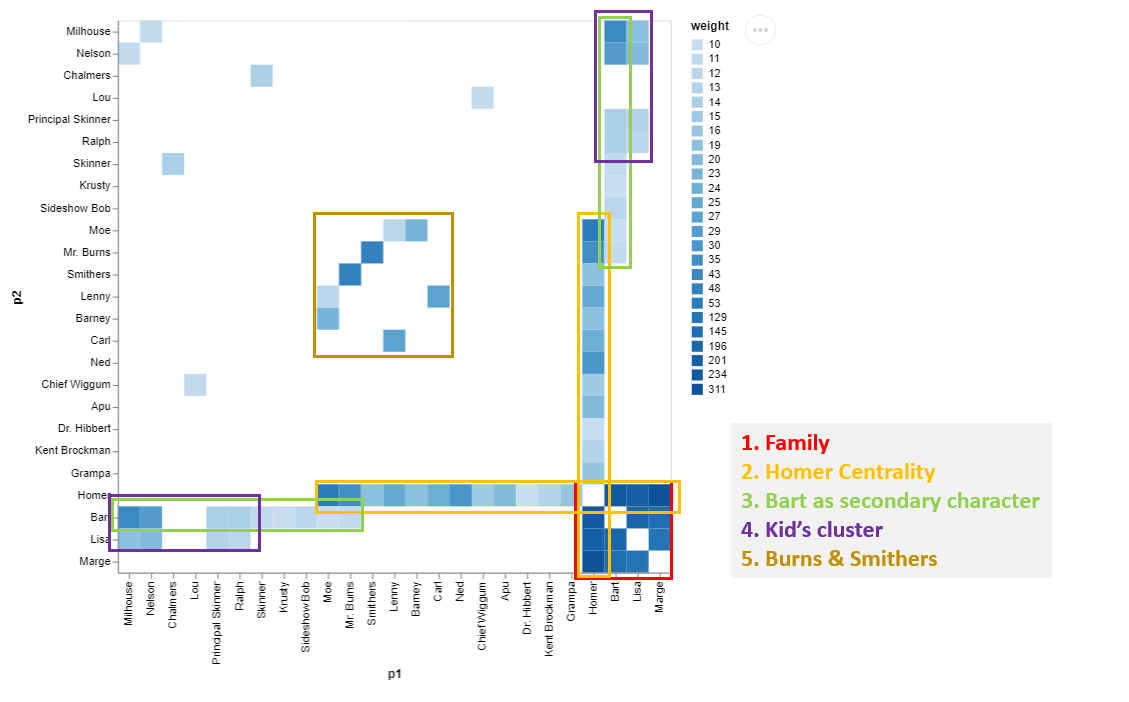When we plot the network as a matrix (with the re-ordered rows/columns) you'll see some interesting patterns develop. Describe what these patterns mean. You can add an annotated screenshot with examples if you need to clarify.

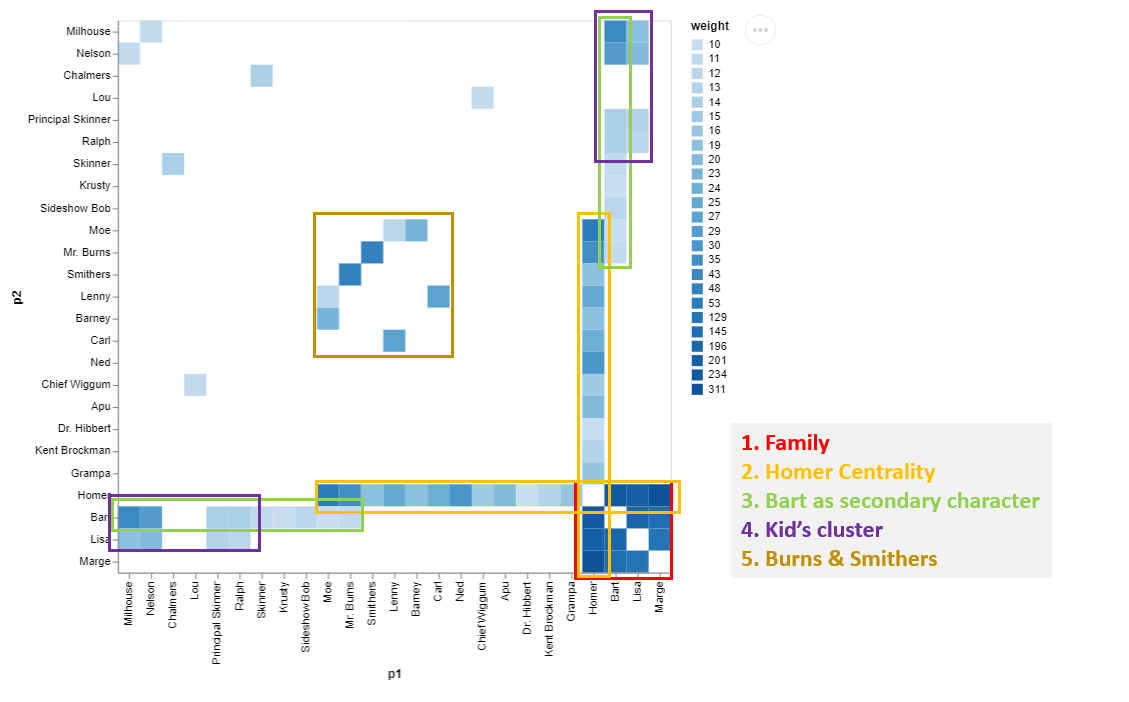

* Pattern 1 - Dense Bottom Right corner -- this pattern highlights the Simpson family's dense interconnections. We can tell from this view that we do not describe characters as interacting with themselves, as evidenced by the diagonal white stripe where characters would align with themselves.
* Pattern 2 - Horizontal and Vertical stripes for Homer Simpson -- This pattern indicates that Homer is a pivotal character in the show, interacting with almost all of the characters seen in these plots. Even if I had no working knowledge of The Simpsons, this would stick out like a sore thumb; This could be a valuable pattern to look for in an unknown social network to determine a key communicator/maven/networker.
* Pattern 3 - Shorter horizontal/Vertical bars for Bart -- Bart has a similar pattern to Homer, but a little less prevalent. Based on his interactions, I'd consider him the secondmost character in The Simpsons. We also start to see a less dense cluster than the family cluster forming in the bottom left/upper right for the kids interactions.
* Pattern 4 - Kids interactions (Lower left/upper right) -- Bart and Lisa interact with a different social group than Homer and Marge. These interactions appear to be primarily with other kids like Milhouse, or Principal Skinner (presumed greater interaction due to the kid's attendance at school, an obviously different social setting than you'd find Homer or Marge in. 
* Pattern 5 - Central pattern about Burns & Smithers -- Burns and Smithers seem highly connected, and they have a few similar friends surrounding them. I haven't watched much of the Simpsons, but I'd imagine Lenny, Barney & Moe are another social group.

**Note**: I accidentally pasted my screencap into the problem 3.3 markdown box. It's a locked cell so I can't remove it; sorry for the mess!